# First EDA project - Analysing house sales data in King County (USA)

### Creator - Tamara Pallien, Data Science Bootcamp neueFische 13.06.- 09.09.2022

## Overview

In this project, data on house sales in King County were analyzed and filtered in such a way to find an area with houses that meet the criteria of a fictional stakeholder. The houses have to be historic, have no waterfront, a big garden, more than 4 bathrooms and should be located close to a Golf resort. 
In the first part the dataset was cleaned for null values or missing entries and filtered according to the above mentioned criteria. This results in a dataframe with 39 sold houses that meet almost all the criteria of the stakeholder. To analyze the location of the house a geographical map is generated and the houses within a 2 km radius to a gold resort selected. Together with the other criteria, the mapping shows that the zipcode area 98177 would be most attractive for the stakeholder. 

## The hypotheses 

There are some general assumptions that have been made in the beginning and these ones will be used and analyzed throughout this notebook. These assumptions/hypotheses are the following: 
1. The houses with a bigger garden cluster in one specific area 
2. There is a correlation of the number of bathrooms with the age of the house 
3. Houses located close to a Golf resort cluster in the North and South from the City Center 
4. The size of the garden of each house is similar to the garden size of the neighboring house 

## The data

The King County Housing Data dataset contains information about home sales in King County (USA).
The dataframe consists of 21597 entries with 21 columns. The columns hold the following information: 

- **id** - unique identified for a house
- **dateDate** - house was sold
- **pricePrice** - is prediction target
- **bedroomsNumber** - # of bedrooms
- **bathroomsNumber** - # of bathrooms
- **sqft_livingsquare** - footage of the home
- **sqft_lotsquare** - footage of the lot
- **floorsTotal** - floors (levels) in house
- **waterfront** - House which has a view to a waterfront
- **view** - Has been viewed
- **condition** - How good the condition is ( Overall )
- **grade** - overall grade given to the housing unit, based on King County grading system
- **sqft_above** - square footage of house apart from basement
- **sqft_basement** - square footage of the basement
- **yr_built** - Built Year
- **yr_renovated** - Year when house was renovated
- **zipcode** - zip
- **lat** - Latitude coordinate
- **long** - Longitude coordinate
- **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
- **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

## The stakeholder 

In this project the fictional stakeholder 'Jacob Phillips' was chosen. He wants to buy a house in the Kind County area. He has unlimited budget, wants 4+ bathrooms or smaller house nearby, big lot (tennis court & pool), golf, historic and no waterfront. 

## Outline 

1) General investigation of the dataset
2) Filtering the dataset according to the stakeholder's taste
3) Show the geographic location of the selected houses 
4) Conclusion and recommendation 

# 1) General investigation of the dataset
For the initial investigation of the dataset, the workflow from Nimit Vanawat was used as kind of the template, since I really like the way he approaches this (https://www.analyticsvidhya.com/blog/2021/08/how-to-perform-exploratory-data-analysis-a-guide-for-beginners/). 

In [81]:
#Import all the required libraries
#load the dataset

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import branca.colormap as cm


In [82]:
df = pd.read_csv('data/King_County_House_prices_dataset.csv')
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639


In [83]:
df.shape

(21597, 21)

As one can see our dataset consists of 21 different columns that contain all the information about the different houses and when they got sold. What I next want to do is to find out if there are any missing values in the dataset. 

In [84]:
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

One can observe, that especially the 'waterfront' and the 'yr_renovated' columns contain a lot of zero values. This makes sense, because of lot of houses probably do not have a waterfront or have not been renovated yet. 
We want to replace the NaN symbols with a '0' to not have problems later during the plotting. In this case it does not make sense to replace the NaN with for example mean values, since I just assume for simplicity, that NaN means that the house does not have a waterfront, have not been viewed or renovated. 
For the waterfront column we can also analyze the mode and use this to replace the empty columns. 

In [85]:
df.waterfront.mode()

0    0.0
Name: waterfront, dtype: float64

In [86]:
#A for loop is used to iterate through all the entries in the three columns and replace the NaN with a 0

change_col = ['waterfront', 'view',  'yr_renovated']
for col in change_col:
    df[col]=pd.to_numeric(df[col])
    df[col].fillna(0, inplace=True)
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639


In [87]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Now, one can see that for example in the 'waterfront' column the value at index No. 0 (first row) which initially showed us a NaN is now giving us a 0.
To get a feeling for which column values might correlate with each other, a heatmap of the whole dataset is generated. 

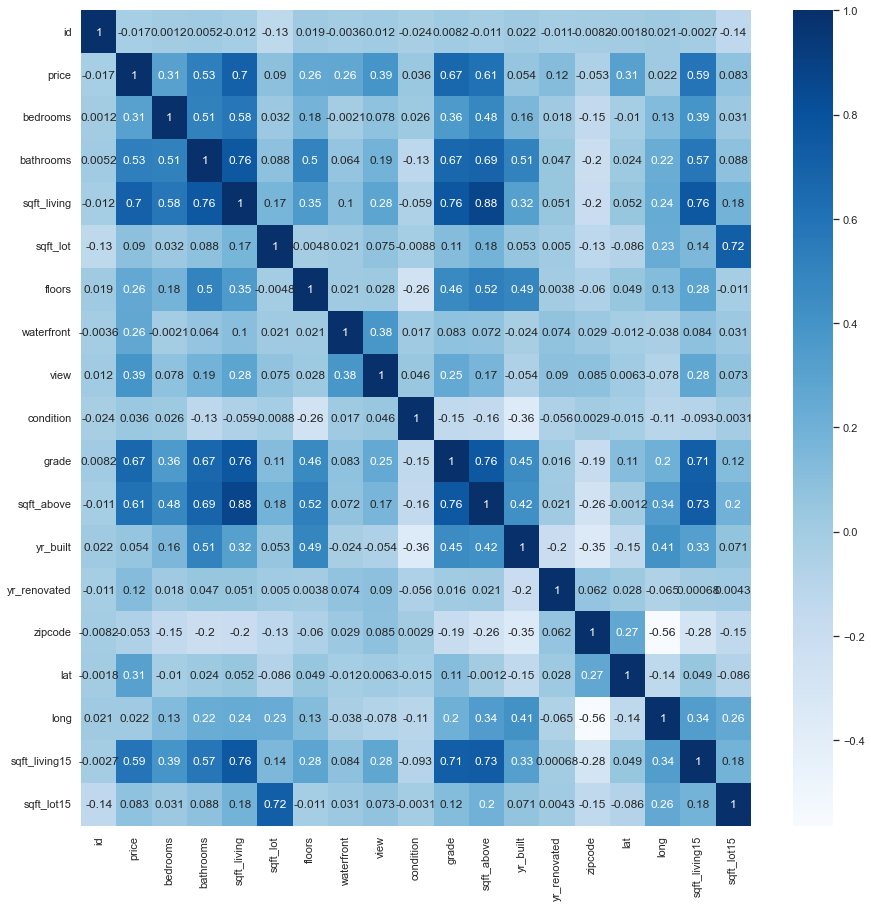

In [88]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),cbar=True,annot=True,cmap='Blues');
#the column information of the data frame is used to label columns and rows 
#annot = True writes the data value in each cell 

This heatmap shows the correlation between the different column values with the values 1 and -1 representing a 100% positive or negative correlation. 
For the parameters that my stakeholder is interested the heatmap shows a positive correlation between the amount of bathrooms and the price. There is also a positive correlation between the amount of bathrooms and the age of the building, indicating that the older buildings have less bathrooms. Further the size of the lot is positively correlated with the lot size of the neighbors. This is what I expected and what was stated in the hypotheses at the beginning of this notebook (hypothesis 2 and 4). 
### Analyze if there is a correlation between house size, lot size and lot size of neighbours

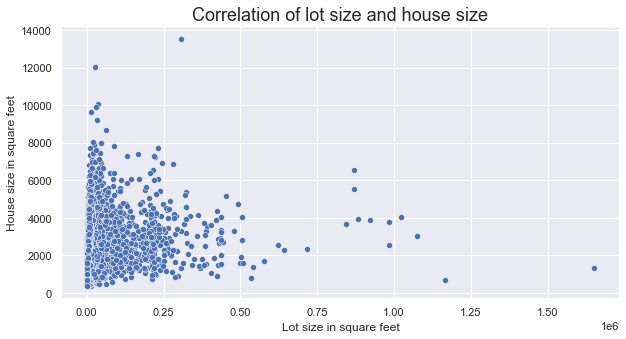

In [89]:
#a seaborn scatterplot is used to analyze the correlation of the two columns defined in x and y 

sns.scatterplot(data=df, x='sqft_lot', y='sqft_living')
plt.title('Correlation of lot size and house size', fontsize=18)
plt.xlabel('Lot size in square feet', fontsize = 12, )
plt.ylabel('House size in square feet', fontsize = 12);

This plot shows that also the smaller lots might have big house, which is slightly different from what I expected. This means, that for example having a big house with more than four bathrooms does not necessarily mean that there is enough space for a swimmimg pool and tennis court. We will later use the garden area alone without the size for the house to determine the treshold. In the next plot the correlation of lot size will be compared to that one of the houses nearby. This would indicate if it makes sense to focus on one area to search for houses, or if this is totally random.

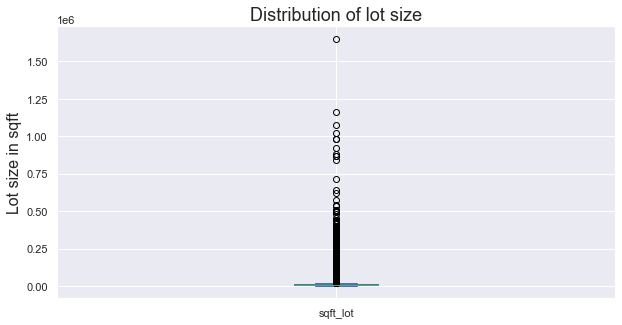

In [90]:
#check the distribution of lot size to eventually remove outliers
df.sqft_lot.plot(kind = 'box')

plt.title('Distribution of lot size', fontsize=18)
plt.ylabel('Lot size in sqft', fontsize=16);

Looking at this graph we see that there a many outliers. We still plot the lot size with the one of the neigbours using scatter plot. 

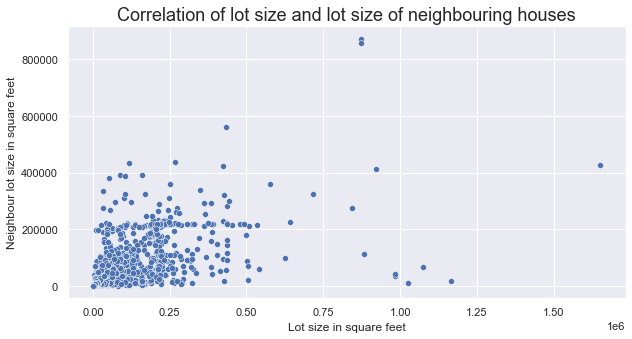

In [91]:
sns.scatterplot(data=df, x='sqft_lot', y='sqft_lot15')
plt.title('Correlation of lot size and lot size of neighbouring houses', fontsize=18)
plt.xlabel('Lot size in square feet', fontsize = 12, )
plt.ylabel('Neighbour lot size in square feet', fontsize = 12);

Due to the high number of outliers, it is hard to see if there is any correlation. For the next plot, we adjust the size of the X-Axis to the size of the y-Axis, meaning all data points above 500,000 sqft will be removed. 
 


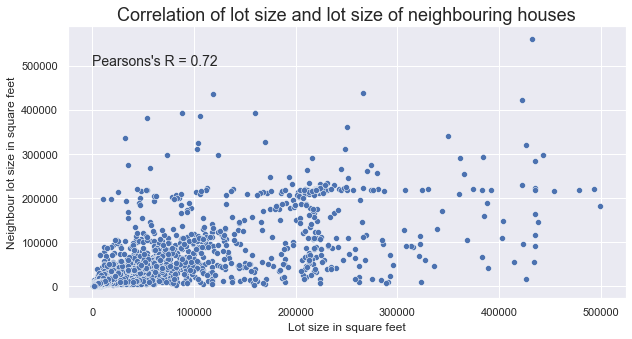

In [92]:
df_small = df.query('sqft_lot < 500000')
sns.scatterplot(data=df_small, x='sqft_lot', y='sqft_lot15')
plt.title('Correlation of lot size and lot size of neighbouring houses', fontsize=18)
plt.xlabel('Lot size in square feet', fontsize = 12, )
plt.ylabel('Neighbour lot size in square feet', fontsize = 12)
plt.text(-5, 500000, "Pearsons's R = 0.72", fontsize = 14);

This plot does not really make it clearer. The Pearson correlation coefficient will be calculated and plotted to get a final idea about if these values within the two columns correlate with each other. 

In [93]:
corr = np.corrcoef(df.sqft_lot, df.sqft_lot15)
#as a result we get a matrix that shows the correlation of the two columns and the column itself (which would be 1)
corr[1,0].round(2)

#so there is a positive correlation between the variables in the two columns. This number is added to the plot above. 

0.72

### Analyze if there is a correlation between number of bathrooms and age 
What might also be interesting is how the amount of bathrooms correlates with the age of the house as was indicated in the heatmap above. 


In [94]:
# Split number of bathrooms in 4 categories for better visualization 
df_baths = pd.cut(df.bathrooms, bins = 3, labels = ['0.5 - 3', '3 - 5.5', '5.5 - 8'])

#we concatenate this now with the df as a new column 
df_baths = df.join(df_baths, how = 'inner', rsuffix = '_cat')
df_baths.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bathrooms_cat
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,0.5 - 3
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,0.5 - 3


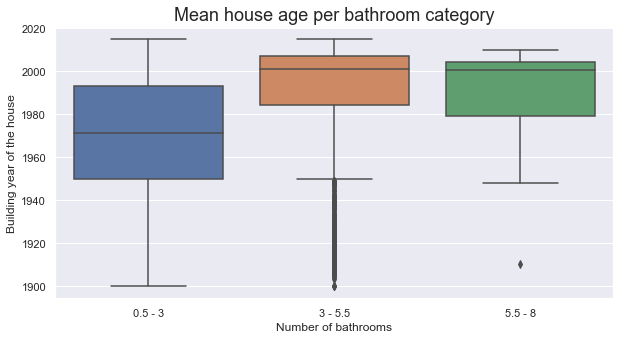

In [120]:
sns.boxplot(data=df_baths, x='bathrooms_cat', y='yr_built')
plt.title('Mean house age per bathroom category', fontsize=18)
plt.xlabel('Number of bathrooms', fontsize = 12, )
plt.ylabel('Building year of the house', fontsize = 12);

There is a trend towards more bathrooms being present in the younger houses (green box). This should be kept in mind for the stakeholder, since he wants a historic house with more than 4 bathrooms (which would be the orange and green box).

One last thing that would be interesting to see is how the overall condition of the house correlates with the age. I would assume that the older houses are proably also not that good in shape which should be considered when thinking about buying a house. 

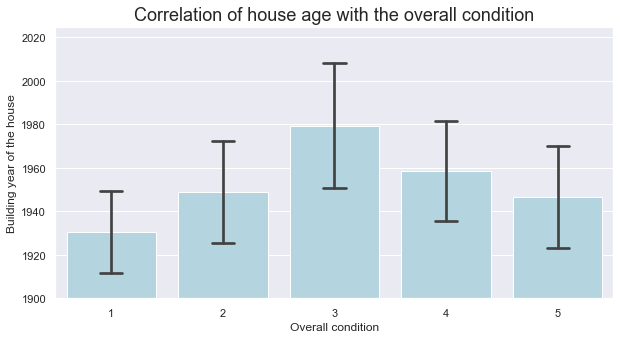

In [96]:
#look at the distribution of house age for the different condition categories
#show mean of the building year with standard deviation grouped by condition category 
#The condition 1 is associated with poor condition and 5 with very good condition (https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#a)

df.condition.sort_values(ascending = False)
sns.barplot(data = df, x = 'condition', y = 'yr_built', color = 'lightblue', estimator = np.mean, ci = 'sd', capsize = .2)
plt.title('Correlation of house age with the overall condition', fontsize=18)
plt.xlabel('Overall condition', fontsize = 12, )
plt.ylabel('Building year of the house', fontsize = 12)
plt.ylim(1900, 2025);

In [97]:
#Here we want to get a table with the mean numbers for the plot above 
df_year_condition_mean = df[['condition', 'yr_built']].groupby('condition').mean().round().reset_index()
df_year_condition_mean

,condition,yr_built
0,1,1930.0
1,2,1949.0
2,3,1979.0
3,4,1958.0
4,5,1946.0


In [98]:
df[['yr_built']].query('yr_built < 1972').count()

yr_built    10279
dtype: int64

In the graph and in the table we see that the houses which are in category 1 were built in average in the year 1930 compared to for example 1979 in category 3. This indicates that in the worse category many houses are quite old. This should be kept in mind when searching for the perfect place. 
Since nearly 50% of the houses in the dataset are considered old, there should be enough houses available to find an old house which is also in good shape.


# 2) Filtering the dataset according to the stakeholder's taste 
After the initial investigation is done, now the more specific analysis and visualization part is following in order to find the perfect area where to look for houses for the stakeholder 'Jacob Phillips'. 
To meet the requirements of the client we need to conduct the following tasks: 
- the client is interested in a house with more than 4 bathrooms -> filter the dataset according to this criterium 
- he does not want a waterfront -> this is the second filter that needs to be applied 
- the lot has to be big -> determine a treshhold to fit the tennis court and swimming pool 
- the house should be historic -> again analyze this column to set the treshold. Also on this website (https://www.rocketmortgage.com/learn/buying-a-historic-home) a historic house is defined as being older than 50 years among other criteria. Here, a historic house is defined as being more than 50 years old.

### Remove all houses with a waterfront 
In this case we need to filter our dataset using the 'query' approach and only select the houses that do not have the waterfront (equals == 0). We will call the new dataframe 'df_no_water'.


In [99]:
#Only select the houses that are not located at the waterfront 

df_no_water = df.query('waterfront == 0')
df_no_water.shape

#this does not really remove many houses, there are much more houses without waterfront 

(21451, 21)

### Select for the houses that are considered as historic
As a next step we want to filter for the historic houses by applying the condition that the houses have to be older than 50 years. Based on the fact that we have year 2022 the building year of the house would need to be lower than 1972. The new dataframe will be called 'df_no_water_historic'. 

In [100]:
#only select for houses which were built before 1972 

df_no_water_historic = df_no_water.query('yr_built < 1972')
df_no_water_historic.sort_values('yr_built').shape

(10191, 21)

Now this new dataframe contains the first two filters, which are no waterfront and historic. Since the stakeholder ideally wants to find a house with at least 4 bathrooms one more filter is going to be applied to the data set. 
### Filter out all houses with less or equal four bathrooms
The new dataframe will be called 'df_no_water_historic_4'. Selecting the only the houses with 4 or more bathrooms leaves us with a dataframe containing only 83 houses, so 0.4 % of the original dataset.

In [101]:
#Next, the dataset is filtered based on the criteria with having equal or more than 4 bathrooms. This will be achieved again with the query function using the dataset that contain no waterfront and historic houses. 
df_no_water_historic_4 = df_no_water_historic.query('bathrooms >= 4')
df_no_water_historic_4.shape

(83, 21)

### Filter dataset for the size of the garden
Next, a new column called garden is created which does not contain the size of the house. The average size of the garden is then plotted agains the zipcode to see in which area we have the biggest gardens to get an idea of which regions might be attractive for the stakeholder.

In [102]:
#A new column will be created which is called garden and this one is the lot size subtracted by the size of the house. 
df_no_water_historic_4.eval('garden = sqft_lot - sqft_living', inplace = True)
df_no_water_historic_4.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,garden
779,1954700695,6/12/2014,2250000.0,5,4.25,4860,9453,1.5,0.0,1.0,...,3100,1760.0,1905,0.0,98112,47.6196,-122.286,3150,8557,4593
1161,3876100320,9/5/2014,482500.0,6,4.50,2940,7500,1.5,0.0,0.0,...,2940,0.0,1966,0.0,98034,47.7208,-122.182,2010,7500,4560


In [103]:
#For the plot we calculate the average garden size and plot this by zipcode 
df_garden_mean = df_no_water_historic_4[['garden', 'zipcode']].groupby('zipcode').mean().round().reset_index()
df_garden_mean['zipcode'] = df_garden_mean['zipcode'].astype(str)
df_garden_mean.sort_values('garden', ascending = False).head(5)

,zipcode,garden
9,98055,56956.0
0,98003,55154.0
25,98166,34184.0
3,98007,31680.0
27,98177,28555.0


This table shows the top 5 areas with the biggest average size of the garden. 

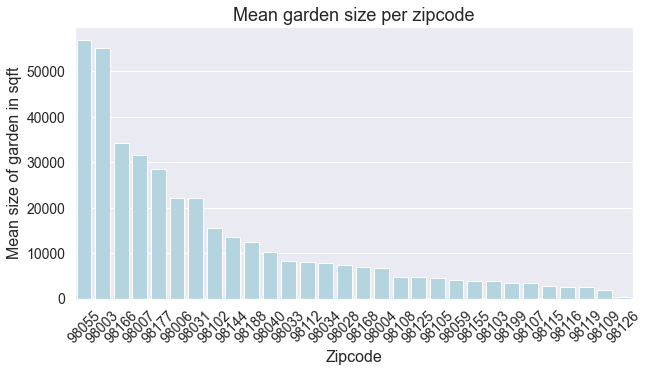

In [104]:
#Now we plot the dataset from above using the zipcode on the x-axis and mean garden size on the y-axis
sns.barplot(data = df_garden_mean, x="zipcode", y="garden", color = 'lightblue', order = df_garden_mean.sort_values('garden', ascending = False).zipcode)
sns.set(rc={'figure.figsize':(10,5)})

plt.title('Mean garden size per zipcode', fontsize=18)
plt.xlabel('Zipcode', fontsize=16)
plt.ylabel('Mean size of garden in sqft', fontsize=16)
plt.xticks(rotation = 45, fontsize = 14)
plt.yticks(fontsize = 14);

So from this graph we can probably select the top five areas that have houses with big gardens, that would fit the stakeholder's interest. 
The corresponding zipcodes are: 98005, 98003, 98166, 98007 and 98177.

Next, we need to analyse and filter the size of the lot. For this, the stakeholder specified that he wants to have a lot big enough to put a tennis court and a pool. The average size of a tennis court is around 2100 square feet. A medium sized swimming pool is around 600 square feet. So our garden needs to be at least 2700 square feet in size to match the stakeholders requirements. And of course than we there should still be some space left for putting other things like a terrace or garage. 
To get an idea how much we can filter the size of the garden a histogram for the garden size is generated.


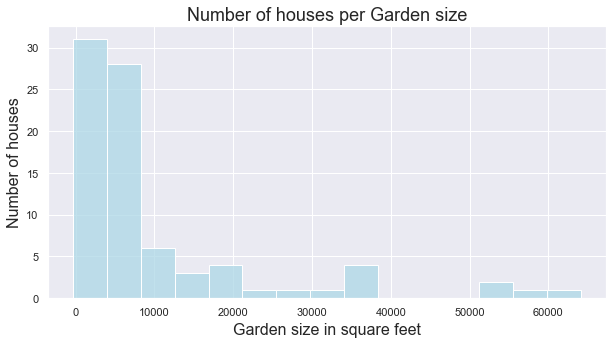

In [105]:
#To plot the size of the garden and the frequency per category we use a histogram
sns.histplot(df_no_water_historic_4.garden,bins=15, color = 'lightblue')
sns.set(rc={'figure.figsize':(10,5)})

plt.title('Number of houses per Garden size', fontsize=18)
plt.xlabel('Garden size in square feet', fontsize=16)
plt.ylabel('Number of houses', fontsize=16);

Based on the distribution and the possibility of having enough space for a swimming pool and a tennis court, the dataset was further filtered for the size of the garden. Therefore we select all houses that have a lot bigger than 5000 square feet. To have even a bit extra space for a terrace and plants. This last filtering step results in a final dataframe with 39 entries, which resembles 0.2% of our starting dataset. 

In [106]:
#Only keep the houses which have a garden bigger than 5000 sqft
df_no_water_4_historic_garden = df_no_water_historic_4.query('garden > 5000')
df_no_water_4_historic_garden.shape

(39, 22)

# 3) Show the geographic location of the selected houses 
One last criteria of the stakeholder is to have a golf area nearby. To analyse this, the location of the remaining houses will be shown on a geographical map. 
Since the stakeholder is looking for a house located close to a golf area, the golf resorst in Seattle were located using GoogleMaps and their coordinates stort in a table outside of this notebook. A 2 km radius was drawn around the golf resort areas to see how many houses are located within or close to this radius. All houses that are located within the radius are defined as being nearby a golf resort. 

In [108]:
#The locations of the golf resorts have been stored in a .csv file in the data folder. The file is imported here.  

df_golf = pd.read_csv('data/Golf.csv', delimiter = ';')
df_golf.head(2)

,lat,long
0,47.674060,-122.154686
1,47.745418,-122.367299


In [122]:
#The map was generated using the folium package and the approach posted by Mina Jambajantsan (https://medium.com/@mina_77131/folium-matplotlib-geopanda-maps-cf503d27c97a)
#The map automatically starts at the Seatlle City Center with the parameters given below 

#First the start point, zoom options and map style are chosen 

from numpy import save


house_map_1 = folium.Map(location=[47.6062, -122.3321],
                    zoom_start=13,
                    tiles='openstreetmap')

#with the popup_text founction when clicking on each symbol we get the information about the ID of the house
#a for loop is used to iterate through all entries of the data frame and derive the parameters below 

for i in df_no_water_4_historic_garden.index:
    lat = df_no_water_4_historic_garden.lat[i]
    long = df_no_water_4_historic_garden.long[i]
    House_id = df_no_water_4_historic_garden.id[i]
    popup_text = "House ID: {}".format(House_id)
    popup = folium.Popup(popup_text, parse_html=True)
    marker = folium.Marker([lat, long], popup=popup).add_to(house_map_1)

    
#iterate trough the list of golf resorts and add them to the map. Use the red symbol with the flag to mark their location.   


for i in df_golf.index: 
    lat_golf = df_golf.lat[i]
    long_golf = df_golf.long[i]
    marker_golf = folium.Marker([lat_golf, long_golf],popup='Golf Resort',icon=folium.Icon(color='red',icon="flag")).add_to(house_map_1)
    marker_golf = folium.Circle([lat_golf, long_golf],radius=2000,color='crimson',fill=False,).add_to(house_map_1)

#A marker for the city center is added. Here the Harborview Medical Center was chosen.                   
folium.Marker(location=[47.605807526291144, -122.32454294176918],popop = 'City Center', icon = folium.Icon(color = 'purple', icon = 'map-marker')).add_to(house_map_1)
house_map_1.save('house_map_1.html')
house_map_1


So in this map it is made clear which houses are located close to a golf resort. In this case the houses located in the north from the city center have four houses that are within the 2 km radius of the golf resort (House ID: 3304700130, 3585900500, 2303900035, 3585901085. As a last step I want to group the houses according to the size of their gardens and give them different colors, so the client can decide which area probably holds the biggest houses. 

In [110]:
#Print out the min and max values in our list to use this for the colorcode 
print(df_no_water_4_historic_garden.garden.min())
print(df_no_water_4_historic_garden.garden.max())

#Based on this we select a range from 5000 to 65000 sqft

5046
64093


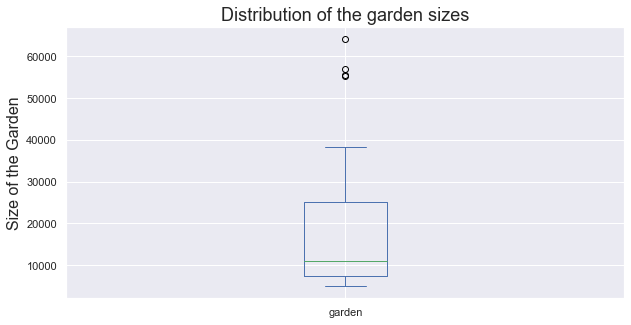

In [111]:
#To make sure there is no outlier, we create a boxplot.
#Since there are a couple of outliers and because the client wants a big garden, I leave those ones in. 

df_no_water_4_historic_garden.garden.plot(kind = 'box')

plt.title('Distribution of the garden sizes', fontsize=18)
plt.ylabel('Size of the Garden', fontsize=16);

In [112]:
#Assign orange for small garden to brown for big garden 
#The code to get the colored circles based on the garden size was found on this page: https://levelup.gitconnected.com/visualizing-housing-data-with-folium-maps-4718ed3452c2

colormap = cm.LinearColormap(colors=['orange', 'gray', 'brown'], vmin=5000, vmax=65000)
colormap.caption = ('Size of garden in sqft')

house_map_2 = folium.Map(location=[47.6062, -122.3321],
                    zoom_start=13,
                    tiles='openstreetmap')
      

for i in range(len(df_no_water_4_historic_garden)):
    folium.Circle(
        location=[df_no_water_4_historic_garden.iloc[i]['lat'], df_no_water_4_historic_garden.iloc[i]['long']],
        radius=1000,
        fill=True,
        color=colormap(df_no_water_4_historic_garden.iloc[i]['garden']),
        fill_opacity=3,
    ).add_to(house_map_2)

for i in df_golf.index: 
    lat_golf = df_golf.lat[i]
    long_golf = df_golf.long[i]
    marker_golf = folium.Marker([lat_golf, long_golf],popup='Golf Resort',icon=folium.Icon(color='red',icon="flag")).add_to(house_map_2)
    
folium.Marker(location=[47.605807526291144, -122.32454294176918],popop = 'City Center', icon = folium.Icon(color = 'purple', icon = 'map-marker')).add_to(house_map_2)

house_map_2.add_child(colormap)
house_map_2

So in this map we can see that the very big houses are located in the north and the south of the city center, but only the ones in the north are the ones closely located to the golf resort. So this area might be the most interesting for the stakeholder. 
Even though the stakeholder is not interested in the prize, it might be interesting to see how the distribution of the price is in the different areas. 


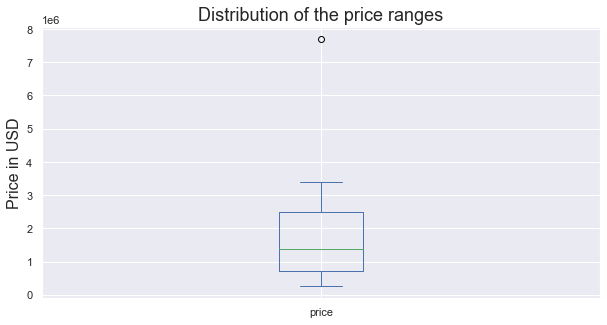

In [113]:
#First the price range has to be determined. For this we first plot the price to make that we do not have a huge outlier. 
df_no_water_4_historic_garden.price.plot(kind = 'box')
plt.title('Distribution of the price ranges', fontsize=18)
plt.ylabel('Price in USD', fontsize=16);

In [114]:
#Indeed there is a huge outlier. So let us analyse the top 5 values and then decide for the maximum value
df_no_water_4_historic_garden[['price']].sort_values('price', ascending = False).head(5)

#So the second price is at around 3.5 Mio USD. So we select this as the maximum number. 

,price
7245,7700000.0
10435,3400000.0
7900,3200000.0
18314,2920000.0
14542,2890000.0


In [115]:
#Select the minimum number for the price range
df_no_water_4_historic_garden.price.min()

#So we select a price range from 250000 to 3500000 USD

265000.0

In [116]:
#Assign green for cheaper prices to red for high price


colormap = cm.LinearColormap(colors=['green', 'yellow', 'red'], vmin=250000, vmax=3500000)
colormap.caption = ('Price in USD')

house_map_3 = folium.Map(location=[47.6062, -122.3321],
                    zoom_start=13,
                    tiles='openstreetmap')
      

for i in range(len(df_no_water_4_historic_garden)):
    folium.Circle(
        location=[df_no_water_4_historic_garden.iloc[i]['lat'], df_no_water_4_historic_garden.iloc[i]['long']],
        radius=1000,
        fill=True,
        color=colormap(df_no_water_4_historic_garden.iloc[i]['price']),
        fill_opacity=3,
    ).add_to(house_map_3)

for i in df_golf.index: 
    lat_golf = df_golf.lat[i]
    long_golf = df_golf.long[i]
    marker_golf = folium.Marker([lat_golf, long_golf],popup='Golf Resort',icon=folium.Icon(color='red',icon="flag")).add_to(house_map_3)

folium.Marker(location=[47.605807526291144, -122.32454294176918],popop = 'City Center', icon = folium.Icon(color = 'purple', icon = 'map-marker')).add_to(house_map_3)

house_map_3.add_child(colormap)
house_map_3

As expected the houses of in the area of choice are among the bit pricier ones. But still, they are cheaper then the ones in the city center which are also smaller. 

So one can see that for the houses in the north, that also meet the other criteria, three of them are within the 2 km radius from the Golf Resort and three other are nearby. 
Based on the house IDs that for the houses which are located in the North at the shoreline, let us check which zipcode area they are in. 

In [117]:
df_final_zip = df_no_water_4_historic_garden[['id', 'zipcode', 'price', 'condition','yr_built']].query('id == 3304700130 or id == 3585900500 or id == 2303900035 or id == 3585901085').sort_values('price')
df_final_zip

,id,zipcode,price,condition,yr_built
5844,3585900500,98177,1530000.0,5,1971
15152,3304700130,98177,1760000.0,4,1927
17665,3585901085,98177,2010000.0,5,1969
14542,2303900035,98177,2890000.0,3,1965


Yay, we found the best area for our stakeholder. 

# 4) Conclusion and recommendation 

Based on all the filters that have been applied the ideal area for the stakeholder 'Jacob Phillips' would be houses in the zipcode area 98177. These houses meet the following criteria: 
- 50% of the houses that have been sold there are within a 2km radius to a Golf resort 
- The area is among the top five areas with the biggest gardens (average garden size = 29,000 sqft)
- The houses are not as cheap as in the south but are still in the medium price range (from 1.5 to 3 Mio USD)
- the selected houses were at least in the medium condition class 

Further things that could be analyzed: 
- how far away are the houses from the city center? 
- what is the best time of the year to buy a house? 
- what are the other houses in the area looking like (for example those ones with less bathrooms)? 
- is there another area with smaller houses that might also fit the other criteria (historic, golf, big garden)(probably start with the other areas that are within the top five garden sizes)? 